In [7]:
import cvxpy
import numpy as np
import qutip
import toqito

from matplotlib import pyplot as plt

In [8]:
from toqito.matrix_props import trace_norm

In [28]:
def upper_bound(Δ): 
    
    φ = np.pi/4
    dim = 2
    npar=2
    outcomes = 4

    Fmat = 1 / ( 2*np.exp(2*Δ)-1 ) * np.identity(npar) 

    ρ = 0.5*np.array( [[ 1. , np.exp(-Δ - 1j*φ) ], [np.exp(-Δ + 1j*φ) , 1. ]] , dtype = np.complex128)
    dΔρ = - 0.5*np.array( [[ 0. , np.exp(-Δ - 1j*φ) ], [np.exp(-Δ + 1j*φ) , 0. ]], dtype = np.complex128 )
    dφρ = - 0.5j*np.array( [[ 0. , np.exp(-Δ - 1j*φ) ], [ - np.exp(-Δ + 1j*φ) , 0. ]], dtype = np.complex128 )

    lΔsorted = [1/(1-np.sqrt(2)*np.exp(Δ)), -1/(1+np.sqrt(2)*np.exp(Δ)), 1/(1+np.sqrt(2)*np.exp(Δ)) ,  1/(-1+np.sqrt(2)*np.exp(Δ)) ]
    Adiags_Δ_sorted = [ (lΔsorted[j]**2)* ρ - 2*lΔsorted[j] * dΔρ for j in range(outcomes) ]
    sigΔ = 1 + ( lΔsorted[0]**2 + lΔsorted[-1]**2 + trace_norm(Adiags_Δ_sorted[0] - Adiags_Δ_sorted[-1]) ) /  (2*Fmat[1,1])

    lφsorted = [ -1/(1+np.sqrt(2)*np.exp(Δ)) , -1/(1+np.sqrt(2)*np.exp(Δ)),  1/(-1+np.sqrt(2)*np.exp(Δ)) , 1/(-1+np.sqrt(2)*np.exp(Δ)) ]
    Adiags_φ_sorted = [ (lφsorted[j]**2)* ρ - 2*lφsorted[j] * dφρ for j in range(outcomes) ]

    sigφ = 1 + ( lφsorted[0]**2 + lφsorted[-1]**2 + trace_norm(Adiags_φ_sorted[0] - Adiags_φ_sorted[-1]) ) /  (2*Fmat[1,1])

    return sigΔ+sigφ

In [29]:
upper_bound(.4)

13.49556529072985

In [ ]:
lφsorted = [ -1/(1+np.sqrt(2)*np.exp(Δ)) , -1/(1+np.sqrt(2)*np.exp(Δ)),  1/(-1+np.sqrt(2)*np.exp(Δ)) , 1/(-1+np.sqrt(2)*np.exp(Δ)) ]
Adiags_φ_sorted = [ (lφsorted[j]**2)* ρ - 2*lφsorted[j] * dφρ for j in range(outcomes) ]

sigφ = 1 + ( lφsorted[0]**2 + lφsorted[-1]**2 + trace_norm(Adiags_φ_sorted[0] - Adiags_φ_sorted[-1]) ) /  (2*Fmat[1,1])
sigφ

5.350185506764176

In [ ]:
NN = cvxpy.Variable((2, 2), hermitian=True)

objective = cvxpy.Maximize( cvxpy.real( cvxpy.trace( Adiags_Δ_sorted[0]@ NN + Adiags_Δ_sorted[-1]@( np.identity(2) - NN ) ) ) )

constraints = [ NN << np.identity(2) , NN >> 0 ]

problem_sing = cvxpy.Problem(objective, constraints)

sol_sing = problem_sing.solve(solver='MOSEK')

1 + sol_sing/Fmat[1,1]

9.215693462540706

In [ ]:
obj_sing = []
POVM_N = []
constraints = []

for i in range(outcomes):
    
    POVM_N.append(cvxpy.Variable((dim, dim), hermitian=True))
    constraints.append( POVM_N[i] >> 0 )
    obj_sing.append( cvxpy.real(cvxpy.trace( (Adiags_Δ_sorted[i]) @ POVM_N[i] ) ) )


constraints.append(sum(POVM_N) == np.identity(dim))

objective = cvxpy.Maximize( sum(obj_sing))

problem_sing = cvxpy.Problem(objective, constraints)

sol_sing = problem_sing.solve(solver='MOSEK')

1 + sol_sing/Fmat[1,1]

9.215693452286262

In [ ]:
sol_sing

7.90766496657096

In [13]:
# Δ = .000001


def FI_MaS_MeNoS(Δ):
    φ = np.pi/4
    dim = 2
    npar=2
    outcomes = 4
    
    ρ = 0.5*np.array( [[ 1. , np.exp(-Δ - 1j*φ) ], [np.exp(-Δ + 1j*φ) , 1. ]] , dtype = np.complex128)
    dΔρ = - 0.5*np.array( [[ 0. , np.exp(-Δ - 1j*φ) ], [np.exp(-Δ + 1j*φ) , 0. ]], dtype = np.complex128 )
    dφρ = - 0.5j*np.array( [[ 0. , np.exp(-Δ - 1j*φ) ], [ - np.exp(-Δ + 1j*φ) , 0. ]], dtype = np.complex128 )

    # For φ = 0
    # lΔ = np.transpose([[ -1//(1+np.exp(Δ)) , 1//(-1+np.exp(Δ))  , 0. , 0. ]])
    # lφ = np.transpose([[ 0, 0, - np.cosh(Δ) + np.sinh(Δ) , np.exp(-Δ) ]])

    # For φ = π/4
    lΔ = np.transpose([[ -1/(1+np.sqrt(2)*np.exp(Δ)) , 1/(-1+np.sqrt(2)*np.exp(Δ)) , 1/(1-np.sqrt(2)*np.exp(Δ)) , 1/(1+np.sqrt(2)*np.exp(Δ)) ]])
    lφ = np.transpose([[ -1/(1+np.sqrt(2)*np.exp(Δ)) , 1/(-1+np.sqrt(2)*np.exp(Δ)) , 1/(-1+np.sqrt(2)*np.exp(Δ)) , -1/(1+np.sqrt(2)*np.exp(Δ)) ]])
    Lmat = np.block([ lφ , lΔ ])

    # Fmat = np.diag( [0.5*np.exp(-2*Δ), 0.25*( 1/np.tanh(Δ) - 1 )] ) # φ = 0

    Fmat = 1 / ( 2*np.exp(2*Δ)-1 ) * np.identity(npar) 
    Fmat_inv = np.linalg.inv(Fmat)

    Amats = [ np.kron(np.outer(Lmat[j],Lmat[j]),ρ) - np.kron( np.array([Lmat[j]]), np.block([[dφρ],[dΔρ]]) ) - np.kron( np.array([Lmat[j]]).T , np.block([dφρ,dΔρ]) ) for j in range(outcomes) ]

    obj_func = []
    POVM_N = []
    constraints = []

    for i in range(outcomes):
        
        POVM_N.append(cvxpy.Variable((dim, dim), hermitian=True))
        
        obj_func.append( cvxpy.real(cvxpy.trace( Amats[i] @ cvxpy.kron(Fmat_inv , POVM_N[i]) )) )
        constraints.append(  POVM_N[i] >> 0 )
        # obj_func_diag.append( cvxpy.real(cvxpy.trace( (Adiags_φ[i]/Fmat[0,0] + Adiags_Δ[i]/Fmat[1,1] ) @ POVM_N[i] ) ) )


    constraints.append(sum(POVM_N) == np.identity(dim))
    objective_full = cvxpy.Maximize(npar + sum(obj_func))
    problem_full = cvxpy.Problem(objective_full, constraints)
    return problem_full.solve(solver='MOSEK')

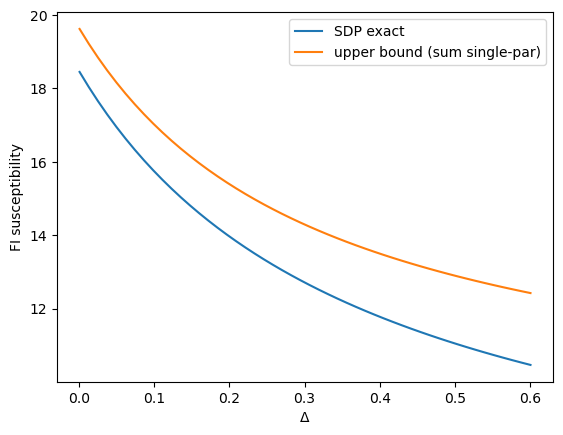

In [34]:
Δs = np.linspace(0.001,0.6,50)
upperΔ = [upper_bound(dd) for dd in Δs ]
resultΔ = [FI_MaS_MeNoS(dd) for dd in Δs ]
plt.plot(Δs,resultΔ,label='SDP exact')
plt.plot(Δs,upperΔ,label='upper bound (sum single-par)')
plt.ylabel('FI susceptibility')
plt.xlabel('Δ')
plt.legend()

In [ ]:
dim = 2
npar=2
outcomes = 4

Amats = [ np.kron(np.outer(Lmat[j],Lmat[j]),ρ) - np.kron( np.array([Lmat[j]]), np.block([[dφρ],[dΔρ]]) ) - np.kron( np.array([Lmat[j]]).T , np.block([dφρ,dΔρ]) ) for j in range(outcomes) ]

Adiags_φ = [ (lφ[j]**2)* ρ - 2*lφ[j] * dφρ for j in range(outcomes) ]
Adiags_Δ = [ (lΔ[j]**2)* ρ - 2*lΔ[j] * dΔρ for j in range(outcomes) ]

obj_func = []
obj_func_alt = []
obj_func_diag = []
POVM_N = []
constraints = []

for i in range(outcomes):
    
    POVM_N.append(cvxpy.Variable((dim, dim), hermitian=True))
    
    obj_func.append( cvxpy.real(cvxpy.trace( Amats[i] @ cvxpy.kron(Fmat_inv , POVM_N[i]) )) )
    constraints.append(  POVM_N[i] >> 0 )
    # obj_func_alt.append( cvxpy.partial_trace( Amats[i] @ cvxpy.kron( np.identity(npar) , POVM_N[i]) , (npar,dim) , axis = 1 ) ) 

    obj_func_diag.append( cvxpy.real(cvxpy.trace( (Adiags_φ[i]/Fmat[0,0] + Adiags_Δ[i]/Fmat[1,1] ) @ POVM_N[i] ) ) )


constraints.append(sum(POVM_N) == np.identity(dim))

objective_full = cvxpy.Maximize(npar + sum(obj_func))
objective_diag = cvxpy.Maximize(npar + sum(obj_func_diag))
# objective = cvxpy.Maximize( npar + cvxpy.real(cvxpy.trace(Fmat_inv@sum(obj_func_alt))) )

problem_full = cvxpy.Problem(objective_full, constraints)

problem_diag = cvxpy.Problem(objective_diag, constraints)

sol_full = problem_full.solve()

sol_diag = problem_diag.solve()

In [ ]:
sol_full

18.485246351793727

In [ ]:
sol_diag

18.48524635178695

In [ ]:
problem.solution

Solution(optimal, {977: array([[ 6.17073566e-11, -1.01108323e-10],
       [-1.01108323e-10,  1.20283256e-10]]), 989: array([[2.53963832e-11, 6.83524309e-11],
       [6.83524309e-11, 1.36734340e-10]]), 1001: array([[1.00000000e+00, 7.90538677e-11],
       [7.90538677e-11, 1.00000000e+00]]), 1013: array([[ 9.32667667e-13, -2.76821932e-11],
       [-2.76821932e-11,  2.87465747e-11]])}, {1030: array([[5.53332063, 0.        ],
       [4.01937997, 3.81072921]])}, {'solve_time': 0.00043487548828125, 'num_iters': 6, 'solver_specific_stats': {'mio_intpnt_iter': 0, 'mio_simplex_iter': 0}})

In [ ]:
sol_default

6.999999999891299

In [ ]:
sol_default

11.344049837016074

In [ ]:
sol_default

17.421139984073175

In [ ]:
rho=
drho=[d1rho,d2rho,...]

In [ ]:

for i in range(npar):
    

problem.    
    